Code snippets for performing embryo segmentations.\
The HPC needs to be used to read the data in Step 1 and write the data in Step 5 since the data are large. Step 5 needs a batch file as it's slow. To get the process right, though, we need to spend some time fiddling with parameters to make sure it's doing the right thing, for which it may be easier to run Steps 2,3,4 on a local machine and have a look at the .tif output in ImageJ.\

Step 0: the following packages should be imported for both HPC and local machine

In [2]:
import numpy as np
import tifffile as tiff
import scipy
import skimage as ski
import matplotlib.pyplot as plt
import time
import os

Step 1: downsample and blur.\
We need to downsample to make subsequent steps computationally feasible
We need to blur enough in order for cells in the same embryo to have the same watershed but not too much that distinct embryos get merged together\
Here, we perform downsampling by (1,12,12) before blurring (to save time on blurring) and then downsample by another (3,3,3) after blurring (to reduce the size of the data)

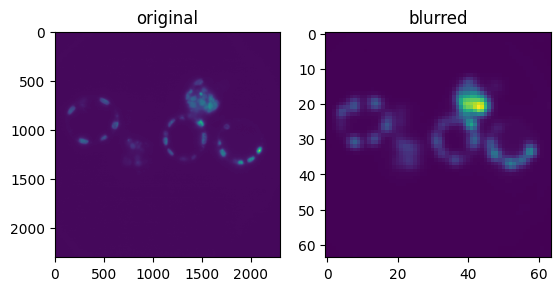

In [33]:
#visualising Step 1 with just one time point
imgarr=tiff.imread("C:/Users/alexy/CMP_code/trial_data/t0135_mcherry.tif")
miniarr=ski.transform.downscale_local_mean(imgarr, (1,12,12), cval=100)
miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=0)[1::3,:,:]
miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=1)[:,1::3,:]
miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=2)[:,:,1::3]

plt.subplot(121)
plt.imshow(imgarr[30,:,:])
plt.title('original')
plt.subplot(122)
plt.title('blurred')
plt.imshow(miniarr[10,:,:])

In [ ]:
#run this code on the hpc
#performing Step 1 on all time points and saving the result:
"""
import numpy as np
import tifffile as tiff
import scipy
import skimage as ski
import matplotlib.pyplot as plt
import time
import os
start_time = time.time()
n_time=135
#create blurred images
for i in range(n_time):
    elapsed_time = time.time() - start_time
    print(f"Iteration {i}: {elapsed_time:.2f} seconds elapsed")
    number_str = str(i+1).zfill(4)
    imgarr=tiff.imread("/rds/project/rds-1FbiQayZlSY/cmp/well6_DNA/intensity/t"+ number_str +"_mcherry.tif")
    miniarr=ski.transform.downscale_local_mean(imgarr, (1,12,12), cval=100)
    miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=0)[::3,:,:]
    miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=1)[:,::3,:]
    miniarr=scipy.ndimage.gaussian_filter(miniarr, 3, mode='reflect', truncate = 2, axes=2)[:,:,::3]
    #tiff.imwrite("/rds/user/ay343/hpc-work/embryo_seg/well6_intensity_micro/t"+ number_str +"_micro.tif", miniarr)
    if i==0:
        downsampled_shape=np.shape(miniarr)
        miniarr4d=np.zeros([n_time]+list(downsampled_shape))
    miniarr4d[i]=miniarr
tiff.imwrite("/rds/user/ay343/hpc-work/embryo_seg/well6_micro_3_36_36.tif",miniarr4d)"""

In [49]:
# if we want to do the rest of the processing locally, then we should download the file
# and then read it, e.g.:
miniarr4d=tiff.imread("C:/Users/alexy/CMP_code/embryo_seg/well6_micro_3_36_36.tif")

Step 2: provide seeds in time point 1 from which to flood. We set the number of embryos, a threshold that separates foreground from background. Then the function n_embryos_maxima finds as many h maxima as there are number of embryos, by brute searching through values of h.

In [53]:
n_embryos=4 #CHANGE ME
threshold=150

def n_embryos_maxima(img,n_embryos,h_bounds=None,attempts=0):
    #find h maxima, where h is chosen to ensure only n_embryos
    img_dtype = img.dtype
    if h_bounds is None:
        h_bounds=(img_dtype.type(0),
                  img_dtype.type(np.max(img)-np.min(img)))
    h_lower=h_bounds[0]
    h_upper=h_bounds[1]
    h_try=(h_lower+h_upper)/2
    candidate_img = ski.morphology.h_maxima(img,h=h_try)
    candidate_idx=candidate_img.nonzero()
    num_nonzero=np.shape(candidate_idx)[1]
    print(f"Current h: {h_try}, current num_nonzero: {num_nonzero}, current dtype: {img_dtype}")
    if attempts==10:
        candidate_img[candidate_idx]=list(range(1,num_nonzero+1))
        return candidate_img, candidate_idx
    attempts+=1
    if num_nonzero>n_embryos:
        return n_embryos_maxima(img,n_embryos,h_bounds=(h_try,h_upper),attempts=attempts)
    elif num_nonzero<n_embryos:
        return n_embryos_maxima(img,n_embryos,h_bounds=(h_lower,h_try),attempts=attempts)
    else:
        candidate_img[candidate_idx]=list(range(1,num_nonzero+1))
        return candidate_img, candidate_idx

img_mask=(miniarr4d[0]>=threshold)
##find h_maxima, giving it as input the transformed image, with some white noise to break ties
img_distance_transform = (scipy.ndimage.distance_transform_edt(img_mask) +
                          np.random.uniform(0,0.1,size=np.shape(img_mask)))
seed_img,seed_idx = n_embryos_maxima(img_distance_transform,n_embryos)
#tiff.imwrite("C:/Users/alexy/CMP_code/embryo_seg/well6_micro_t0001_relief.tif",img_distance_transform)

Current h: 2.2932775228692446, current num_nonzero: 4, current dtype: float64


Step 3: to aid the flooding in the temporal direction, we blur in the temporal dimension

In [54]:
sigma_t=1
miniarr4d_tblur=scipy.ndimage.gaussian_filter(miniarr4d, sigma_t, mode='nearest', truncate = 4, axes=0)

Step 4: perform watershed on the full 4d blurred intensity image. This is the main idea!\
We choose not to use apply distance-to-background transform, as we are not going to be segmenting a convex shape\

In [55]:
img_mask_4d=(miniarr4d_tblur>=threshold)
seed_img_4d=np.zeros(np.shape(img_mask_4d),np.uint8)
seed_img_4d[0]=seed_img
watershed_out_4d = ski.segmentation.watershed(-miniarr4d_tblur,seed_img_4d,mask=img_mask_4d)
tiff.imwrite("C:/Users/alexy/CMP_code/embryo_seg/well6_micro_watershed_4d.tif", watershed_out_4d)

Note: the embryo numbers in the output won't match the numbers that Anita used, so we'll manually correct that before proceeding:

In [56]:
watershed_4d = tiff.imread("C:/Users/alexy/CMP_code/embryo_seg/well6_micro_watershed_4d.tif")
new_labels=np.array([0, 1, 3, 2, 4],dtype=np.uint8) #this should be [0, 4, 2, 1, 3] for well-5, [0, 1, 3, 2, 4] for well-6, and no action needed for well-3
watershed_4d_relabelled = np.take(new_labels,watershed_4d)
tiff.imwrite("C:/Users/alexy/CMP_code/embryo_seg/well6_micro_watershed_4d.tif", watershed_4d_relabelled)


Step 5: Retrieve a mask for each embryo. We suggest:\
(a) taking the convex hull of each mask\
(b) using a binary dilation on each mask (by perhaps ~2 pixels) to retrieve some of the edges that we threw away\
(c) upsampling by (3,36,36) to get back to original size\
    To implement upsampling of a mask ``minimask``, we initialise an empty array ``mask`` at original size and populate it with the values of ``mask`` at certain gridpoints, and use convex hull to fill in the gaps\

In [ ]:
#run step 5 on the hpc
"""
import tifffile as tiff
import numpy as np
import skimage
import os
import scipy
import time

#parameters
wells=[3,5,6]
n_embryos=[3,4,4]
n_time=135
destination = "/rds/user/ay343/hpc-work/embryo_seg/outputs/"

#define things to use later
start_time = time.time()
imgarr=tiff.imread("/rds/project/rds-1FbiQayZlSY/cmp/well3_DNA/intensity/t0001_mcherry.tif") ##just to retrieve the size
full_shape=[n_time]+list(np.shape(imgarr))
               
def flood_fill_hull(image):    
    points = np.transpose(np.where(image))
    hull = scipy.spatial.ConvexHull(points)
    deln = scipy.spatial.Delaunay(points[hull.vertices]) 
    idx = np.stack(np.indices(image.shape), axis = -1)
    out_idx = np.nonzero(deln.find_simplex(idx) + 1)
    out_img = np.zeros(image.shape)
    out_img[out_idx] = 1
    return out_img

#get masks
for well_idx,well in enumerate(wells):
    #specify where the data is
    watershed_out_4d = tiff.imread(f"/rds/user/ay343/hpc-work/embryo_seg/well{well}_micro_watershed_4d.tif")
    for embryo_idx in range(n_embryos[well_idx]):
        minimask=(watershed_out_4d==embryo_idx+1)
        mask=np.zeros(full_shape,np.bool)
        for t in range(n_time):
            elapsed_time = time.time() - start_time
            print(f"Well {well}, embryo {embryo_idx+1}, time {t}: {elapsed_time:.2f} seconds elapsed")
            minimask[t]=flood_fill_hull(minimask[t])
            minimask[t]=scipy.ndimage.binary_dilation(minimask[t], iterations=2)
            mask[t]=minimask[t].repeat(3, axis=0).repeat(36, axis=1).repeat(36, axis=2)[0:full_shape[1],0:full_shape[2],0:full_shape[3]]
        tiff.imwrite(destination+f"well{well}_em{embryo_idx+1}_mask.tif",mask)
"""

MemoryError: Unable to allocate 60.7 GiB for an array with shape (135, 91, 2304, 2304) and data type uint8